# Coastal Satellite Image Classification with CNN


## Author: Arash Shamseddini

In this script, I will make an attempt to build a Neural Network that is able to classify coastal Satellite Images as containing buildings/development ("developed") or not ("natural"). In other words,  the model would be able to determine if a satellite image of a coastal landscape contains man-made structures (**developed**) or not (**natural**).

But why this claasification would be of any interest?

Identifying areas of coastline that have structures on them is important for a range of purposes:
- Determining areas at risk of sea level rise;
- Identifying areas at high risk of storm damage;
- etc.

For example, below is an image of **developed** coastline.

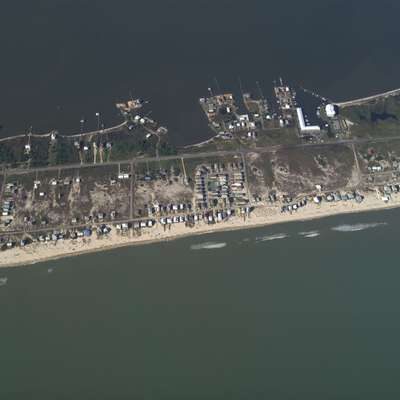

while below is an example of a **natural** coastline.


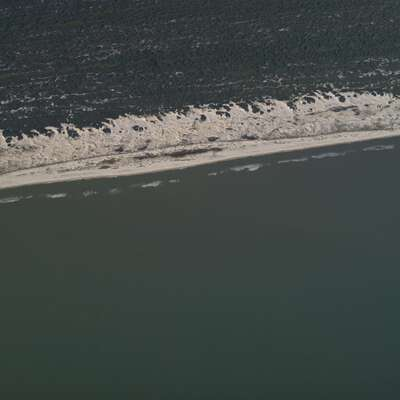

For the modeling, I would do two things:

- A binary classification CNN built from scratch that can identify "developed" and "natural" coastlines, i.e., the model accepts an image as input and will classify it as "developed" or "natural".
- A pre-trained model customised with your own layer(s) on top using [Transfer Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) again to build a binary classifier CNN that can identify "developed" and "natural" coastlines.

and finally compare the two mdels.

In [1]:
# Necessary imports

import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})

### 1- The Dataset

The dataset for this analysis contains **2186** images of both developed and natural coastlines. This dataset can be found on Kaggle Datasets under the name **"DSCI572-satellite-transfer"** for which the inspiration is attributed to [Tom Beuzen](https://www.tomasbeuzen.com/).

Here is a look at some sample images from the train set.

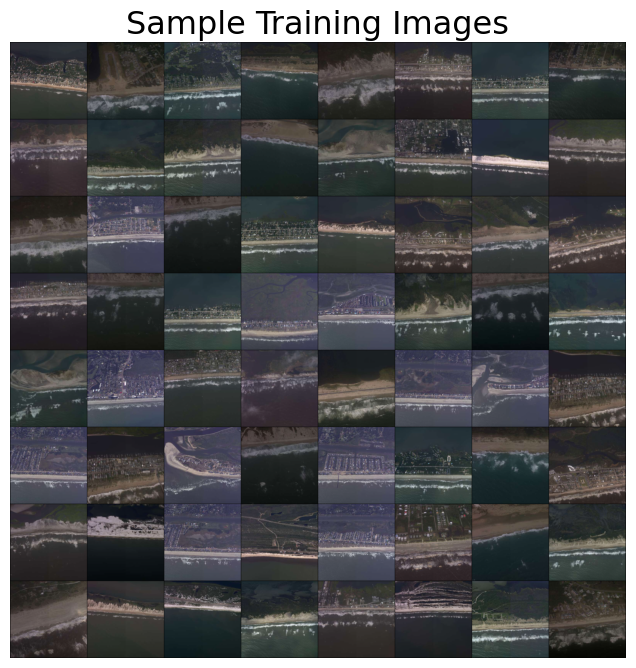

In [2]:
# Set specs
TRAIN_DIR = "../input/dsci572satellitetransfer/labelled/train/"
VALID_DIR = "../input/dsci572satellitetransfer/labelled/validation/"
IMAGE_SIZE = 200
BATCH_SIZE = 64

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

# Create train dataloader
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

### 2- GPU

To speed up the back-end computation, it would be best to build this model on a GPU machine. This is why I would take advantage of Kaggle's cloud GPU which is the main reason why this script originally exists on a Kaggle notebook. Kaggle offers 30+ hours of free GPU usage per week which should be much more than adequate for this script.

However, there will be a copy of this script on GitHub [here](https://github.com/arashshams/Coastal_Satellite_Image_Classifier_CNN).

To get started, follow these steps:
- On the right-hand side of your Kaggle notebook, make sure the internet is enabled.
- In the Accelerator dropdown, choose GPU when you're ready to use it (feel free to turn it on/off as you need it).

In Kaggle, running the follow cell should print out `"Using device: cuda"` which means a GPU is available:

In [3]:
# Check for CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


### 3- Modeling

####  3-1 CNN from Scratch

For this model, I will build a CNN from scratch. Here are some of the considerations I will make in building the model:
- The raw images are **400 x 400** pixels, and since we don't need them that big I will convert them to **200 x 200**.
- I will train the model for **20** epochs. To avoid potential overfitting, I will define a custom-made "[Early Stopping](https://www.educba.com/pytorch-early-stopping/)".
- I will use batch size of **64** meaning each batch in both the train and test sets contains 64 images.

In [4]:
### CNN from Scratch ###

# Transforms
data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

# Load data and create dataloaders
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Create the CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Flatten(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out
model = CNN()
model.to(device)

# Create trainer wrapper
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            y_hat_labels = torch.sigmoid(y_hat) > 0.5        # convert probabilities to False (0) and True (1)
            loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch
        train_loss.append(train_batch_loss / len(trainloader))     # loss = total loss in epoch / number of batches = loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()  # this turns off those random dropout layers, we don't want them for validation!
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()  # Forward pass to get output
                y_hat_labels = torch.sigmoid(y_hat) > 0.5        # convert probabilities to False (0) and True (1)
                loss = criterion(y_hat, y.type(torch.float32))   # Calculate loss based on output
                valid_batch_loss += loss.item()                  # Add loss for this batch to running total
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()   # Average accuracy for this batch  
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        model.train()  # turn back on the dropout layers for the next training loop
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    return results

# Train the model (on GPU) and store the results
model = CNN()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, train_loader, valid_loader, epochs=20, patience=3)

Using: cuda
Epoch 1: Train Loss: 0.652. Valid Loss: 0.782. Train Accuracy: 0.61. Valid Accuracy: 0.50.
Epoch 2: Train Loss: 0.568. Valid Loss: 0.697. Train Accuracy: 0.69. Valid Accuracy: 0.66.
Epoch 3: Train Loss: 0.496. Valid Loss: 0.876. Train Accuracy: 0.76. Valid Accuracy: 0.62.
Epoch 4: Train Loss: 0.462. Valid Loss: 0.764. Train Accuracy: 0.77. Valid Accuracy: 0.65.
Epoch 5: Train Loss: 0.409. Valid Loss: 0.751. Train Accuracy: 0.81. Valid Accuracy: 0.66.
Epoch 6: Train Loss: 0.379. Valid Loss: 0.821. Train Accuracy: 0.84. Valid Accuracy: 0.61.
Epoch 7: Train Loss: 0.362. Valid Loss: 0.970. Train Accuracy: 0.85. Valid Accuracy: 0.62.
Epoch 8: Train Loss: 0.360. Valid Loss: 0.951. Train Accuracy: 0.84. Valid Accuracy: 0.60.
Epoch 9: Train Loss: 0.345. Valid Loss: 0.988. Train Accuracy: 0.85. Valid Accuracy: 0.60.
Epoch 10: Train Loss: 0.305. Valid Loss: 0.819. Train Accuracy: 0.87. Valid Accuracy: 0.60.
Epoch 11: Train Loss: 0.303. Valid Loss: 0.884. Train Accuracy: 0.87. Valid A

Now let's take a look at the train/validation accuracy over the epochs.

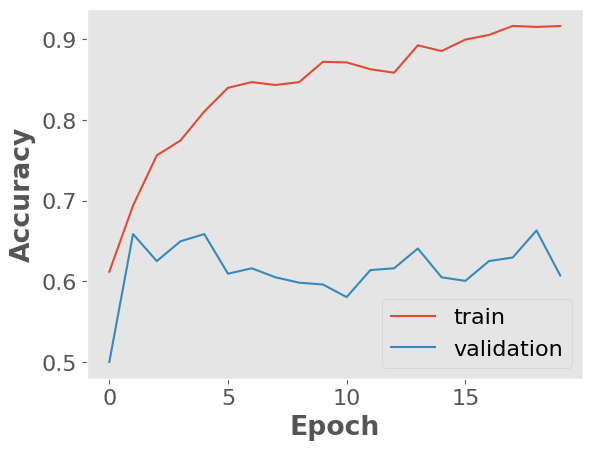

In [5]:
# Plot train/validation accuracy
plt.figure()
plt.plot(results['train_accuracy'])
plt.plot(results['valid_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

In [6]:
# Printing the results
print("Mean Training Accuracy: ", np.mean(results['train_accuracy']))
print("Mean Validation Accuracy: ", np.mean(results['valid_accuracy']))

Mean Training Accuracy:  0.8409542416887625
Mean Validation Accuracy:  0.6148437500000001


Although the model underfits the training data, the plot shows signs of overfitting as the epoch progresses.

Now let's build the second model using a pre-trained model.

#### 3-2: Feature Extractor (Transfer Learning)

For this part, I will leverage a pre-trained model customised with my own layers.

I will customize the "[densenet](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803)" model.

In [7]:
# Load the model (without freeze)
densenet = models.densenet121(pretrained=True)

# Replace classification layer
new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 1))
]))
densenet.classifier = new_layers

# Define trainer wrapper
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat, y.type(torch.float32))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat, y.type(torch.float32))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}


# Train the model (on GPU) and store the results
densenet.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s] 


Epoch 1: Train Accuracy: 0.92. Valid Accuracy: 0.72.
Epoch 2: Train Accuracy: 0.97. Valid Accuracy: 0.69.
Epoch 3: Train Accuracy: 0.98. Valid Accuracy: 0.65.
Epoch 4: Train Accuracy: 0.98. Valid Accuracy: 0.96.
Epoch 5: Train Accuracy: 0.99. Valid Accuracy: 0.76.
Epoch 6: Train Accuracy: 0.99. Valid Accuracy: 0.74.
Epoch 7: Train Accuracy: 0.99. Valid Accuracy: 0.93.
Epoch 8: Train Accuracy: 0.99. Valid Accuracy: 0.94.
Epoch 9: Train Accuracy: 0.99. Valid Accuracy: 0.74.
Epoch 10: Train Accuracy: 1.00. Valid Accuracy: 0.81.
Epoch 11: Train Accuracy: 1.00. Valid Accuracy: 0.77.
Epoch 12: Train Accuracy: 0.99. Valid Accuracy: 0.69.
Epoch 13: Train Accuracy: 0.98. Valid Accuracy: 0.73.
Epoch 14: Train Accuracy: 0.99. Valid Accuracy: 0.77.
Epoch 15: Train Accuracy: 1.00. Valid Accuracy: 0.78.
Epoch 16: Train Accuracy: 0.99. Valid Accuracy: 0.72.
Epoch 17: Train Accuracy: 1.00. Valid Accuracy: 0.79.
Epoch 18: Train Accuracy: 1.00. Valid Accuracy: 0.70.
Epoch 19: Train Accuracy: 1.00. Valid

Now let's take a look at the train/validation accuracy over the epochs.

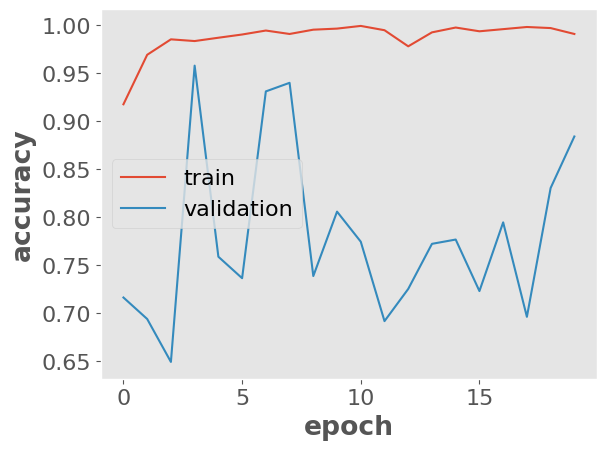

In [8]:
# Plot train/validation accuracy
plt.figure()
plt.plot(results['train_accuracy'])
plt.plot(results['valid_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [9]:
# Printing the results
print("Mean Training Accuracy: ", np.mean(results['train_accuracy']))
print("Mean Validation Accuracy: ", np.mean(results['valid_accuracy']))

Mean Training Accuracy:  0.9870368303997177
Mean Validation Accuracy:  0.7799107142857143


Based on the results so far, although the mean accuracy of the "**Feature Extractor**" model is higher than that of the "**From Scratch**" model, the former model seems to be overfitting in some epochs.

Now let's see if there is a way to fine tune the better performing model.

#### 3-3 Fine-tuned Densenet

Here I will try to fine tune the densenet model by updating the classification layer during training. 

In [10]:
# Replace classification layer
new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(500, 1))
]))
densenet.classifier = new_layers

# Freeze all but the last two layers
for layer in densenet.features[:-2]:
    for param in layer.parameters():
        param.requires_grad = False

# Train the model (on GPU) and store the results
densenet.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(densenet.parameters())
result = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

Epoch 1: Train Accuracy: 0.97. Valid Accuracy: 0.80.
Epoch 2: Train Accuracy: 1.00. Valid Accuracy: 0.77.
Epoch 3: Train Accuracy: 1.00. Valid Accuracy: 0.86.
Epoch 4: Train Accuracy: 1.00. Valid Accuracy: 0.82.
Epoch 5: Train Accuracy: 1.00. Valid Accuracy: 0.85.
Epoch 6: Train Accuracy: 1.00. Valid Accuracy: 0.81.
Epoch 7: Train Accuracy: 1.00. Valid Accuracy: 0.85.
Epoch 8: Train Accuracy: 1.00. Valid Accuracy: 0.98.
Epoch 9: Train Accuracy: 1.00. Valid Accuracy: 0.92.
Epoch 10: Train Accuracy: 1.00. Valid Accuracy: 0.86.
Epoch 11: Train Accuracy: 1.00. Valid Accuracy: 0.85.
Epoch 12: Train Accuracy: 1.00. Valid Accuracy: 0.90.
Epoch 13: Train Accuracy: 1.00. Valid Accuracy: 0.93.
Epoch 14: Train Accuracy: 1.00. Valid Accuracy: 0.96.
Epoch 15: Train Accuracy: 1.00. Valid Accuracy: 0.98.
Epoch 16: Train Accuracy: 1.00. Valid Accuracy: 0.93.
Epoch 17: Train Accuracy: 1.00. Valid Accuracy: 0.95.
Epoch 18: Train Accuracy: 1.00. Valid Accuracy: 0.95.
Epoch 19: Train Accuracy: 1.00. Valid

Now let's take a look at the train/validation accuracy over the epochs and see how the tuning has affected this metric.

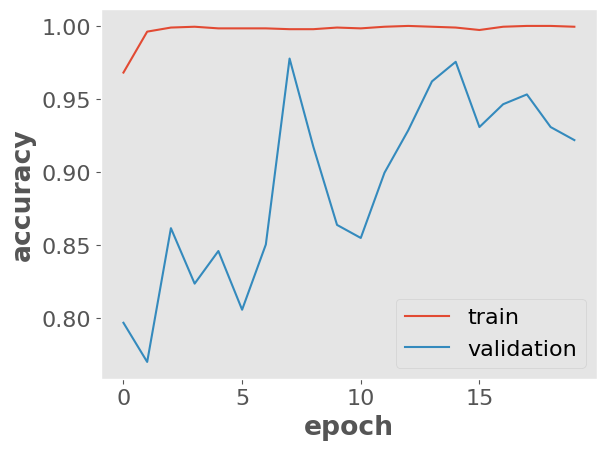

In [12]:
# Plot train/validation accuracy
plt.figure()
plt.plot(result['train_accuracy'])
plt.plot(result['valid_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [14]:
# Printing the results
print("Mean Training Accuracy: ", np.mean(result['train_accuracy']))
print("Mean Validation Accuracy: ", np.mean(result['valid_accuracy']))

Mean Training Accuracy:  0.9972042410501413
Mean Validation Accuracy:  0.8908482142857143


Based on above results, both the mean training and validation accuracies for the "**Fine-tuned Densenet**" model are higher than that of the "**Feature Extractor**" and "**From Scratch**" models. However, the model seems to be making random predictions on the validation set. Also, we can observe an oscillating trend in validation accuracy.

### 4- Conclusion

A CNN classifier was built in two different ways to classify coastal satellite images into two main categories, namely "developed" and "natural". Accuracy was selected as a metric to compare the performance of these models.

Results showed that the model that was built from scratch performed relatively poor compared to the model that was built off of Densenet. Besides, it was possible to improve the Densenet model by fine tuning the final classifier layer. 

Having said that, all of these options could be potentially improved with further optimization which was not the intention of this analysis.

**This is the end of the notebook.**